In [1]:
import os
import numpy as np
import pandas as pd
import umap
import time
from Bio import SeqIO
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Patch
os.chdir('/biodata/franco/zsuzsa_lab/jupyter')
import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'mono', fontsize = 10, colors = 'banskt', dpi = 100)
from tqdm import tqdm

In [2]:
import collections
import json 
import copy

disprot_dict = collections.defaultdict(dict)

with open("/biodata/franco/zsuzsa_lab/disprot_OK_shortseq.fasta") as instrm:
    for record in SeqIO.parse(instrm, "fasta"):
            disprot_dict[record.id]['seq'] = str(record.seq)

with open("/biodata/franco/datasets/disprot/disprot_OK_fullset_annotations_2023_12.fasta") as instrm:
    for record in SeqIO.parse(instrm, "fasta"):
            if record.id in disprot_dict:
                disprot_dict[record.id]['disorder'] = str(record.seq)


def load_secondary_structure(protein_dict):
    complete_counter = 0
    incomplete_counter = 0
    none_counter = 0
    nofile_counter = 0
    complete_label = "consensus_0.75"
    incomplete_label = "consensus_0.75_inc"

    new_protein_dict = copy.deepcopy(protein_dict)

    for uniprot_id in protein_dict:
        #print(uniprot_id)
        ss_file = f"mobidb_dev_10_2024_SSannotated/consensus/{uniprot_id}_consensus.json"
        fullpdb_file = f"mobidb_dev_10_2024_SSannotated/{uniprot_id}.json"
        if os.path.exists(ss_file):
            with open(ss_file) as f:
                ss_data_dict = json.load(f)
            with open(fullpdb_file) as f:
                pdb_data_dict = json.load(f)
            if pdb_data_dict[uniprot_id]['stats']['complete'] > 0:
                # get complete
                ss_seq = ss_data_dict[uniprot_id][complete_label]
                complete_counter += 1
            elif pdb_data_dict[uniprot_id]['stats']['incomplete'] > 0:
                # get incomplete
                ss_seq = ss_data_dict[uniprot_id][incomplete_label]
                incomplete_counter += 1
            else:
                # get any, they should all be "-"
                ss_seq = ss_data_dict[uniprot_id][complete_label]
                none_counter += 1
        else:
            # print(f"{ss_file} json file does not exist")
            nofile_counter += 1
            ss_seq = "".join(["-" for i in range(len(protein_dict[uniprot_id]['seq']))])
        new_protein_dict[uniprot_id]['ss'] = ss_seq
        if len(new_protein_dict[uniprot_id]['ss']) != len(new_protein_dict[uniprot_id]['seq']):
            raise

    print(f"complete:{complete_counter}, incomplete:{incomplete_counter}, nodata:{none_counter}, nofile:{nofile_counter}")
    return new_protein_dict

disprot_dict = load_secondary_structure(disprot_dict)

complete:435, incomplete:522, nodata:243, nofile:190


In [42]:

disprot_dict_full = collections.defaultdict(dict)

with open("/biodata/franco/datasets/disprot/disprot_OK_fullset_2023_12.fasta") as instrm:
    for record in SeqIO.parse(instrm, "fasta"):
            disprot_dict_full[record.id]['seq'] = str(record.seq)

with open("/biodata/franco/datasets/disprot/disprot_OK_fullset_annotations_2023_12.fasta") as instrm:
    for record in SeqIO.parse(instrm, "fasta"):
            disprot_dict_full[record.id]['disorder'] = str(record.seq)

disprot_dict_full = load_secondary_structure(disprot_dict_full)

complete:669, incomplete:1065, nodata:355, nofile:433


In [22]:
#len(disprot_dict.keys())

def load_match_data(protein_dict, datadir):
    protein_matches_data = dict()
    missing_count = 0
    missing_files = []
    for protein_id in protein_dict:
        match_file = f"{datadir}/{protein_id}.json"
        if os.path.exists(match_file):
            with open(match_file) as f:
                protein_matches_data[protein_id] = json.load(f)[protein_id]['aamask_1']
        else:
            missing_files.append((protein_id, match_file))
            missing_count += 1
    print(f"Missing {missing_count} files")
    print(f"Loaded {len(protein_matches_data.keys())} files")
    return protein_matches_data

disprot_matches_data_autoreg = load_match_data(disprot_dict, "/biodata/franco/zsuzsa_lab/loss_T5_disprot_short_autoreg")
disprot_matches_data         = load_match_data(disprot_dict, "/biodata/franco/zsuzsa_lab/loss_T5_disprot2_cuda")

Missing 831 files
Loaded 559 files
Missing 189 files
Loaded 1201 files


In [23]:
aa_vocabulary = "ACDEFGHIKLMNPQRSTVWY"
aa_vocab_list = list(aa_vocabulary)
AA2num = dict(zip(sorted(list(set([i for i in aa_vocabulary]))),np.arange(20)))
AA2num['</s>'] = 20
AA2num['X'] = 21
num2AA = dict(zip(np.arange(20),sorted(list(set([i for i in aa_vocabulary])))))
num2AA[20] = "</s>"
num2AA[21] = "X"
print(len(aa_vocab_list))

20


In [55]:
# # Contains mismatches for each sequence, in the format of a dict with relative positiones of each mismatch
# # 0-based indexing, mismatch at the masked position +1 position forwards, -1 backwards
# # With this, then I can then stratify by protein length and disorder content the mismatch counts and distances to mask!
# mismatch_count_dict = dict()
# # it only depends on where the mask token was put! not where the mismatch happens
# mismatch_count_dict_maskdiso = dict()  
# mismatch_count_dict_maskordr = dict()
# mismatch_count_dict_maskH = dict()  
# mismatch_count_dict_maskB = dict()
# mismatch_count_dict_maskU = dict()
# mismatch_count_dict_maskM = dict()

# mismatch_count_dict_maskdiso_context_dc = dict()  
# mismatch_count_dict_maskordr_context_dc = dict()

# # in this case, depends where the mismatch happens, not where the mask token was put
# mismatch_count_dict_mismdiso = dict()  
# mismatch_count_dict_mismordr = dict()

# wrong_aa = list()
# not_valid_aa = list()
# total_residues_order = 0
# total_residues_disorder = 0
# total_residues_H = 0
# total_residues_B = 0
# total_residues_U = 0
# total_residues_M = 0

# total_residues_D_by_length = collections.defaultdict(int)
# total_residues_O_by_length = collections.defaultdict(int)
# total_residues_H_by_length = collections.defaultdict(int)
# total_residues_B_by_length = collections.defaultdict(int)
# total_residues_U_by_length = collections.defaultdict(int)
# total_residues_M_by_length = collections.defaultdict(int)

# each_bin_totals_match = collections.defaultdict(int)

# length_mismatch_dict = collections.defaultdict(list)

# for disprot_id in tqdm(disprot_matches_data.keys()):
#     seq = disprot_dict[disprot_id]['seq']
#     ss_seq = disprot_dict[disprot_id]['ss']
#     disorder = disprot_dict[disprot_id]['disorder']
#     matches = disprot_matches_data[disprot_id]['match']

#     diso_ix = [True if e != "-" else False for e in disorder ]
#     total_residues_order += len([e for e in diso_ix if e == False])
#     total_residues_disorder += len([e for e in diso_ix if e == True])

#     H_ix = [True if e == "H" else False for e in ss_seq]
#     B_ix = [True if e == "B" else False for e in ss_seq]
#     U_ix = [True if e == "U" else False for e in ss_seq]
#     M_ix = [True if e == "M" else False for e in ss_seq]
#     total_residues_H += len([e for e in H_ix if e == True])
#     total_residues_B += len([e for e in B_ix if e == True])
#     total_residues_U += len([e for e in U_ix if e == True])
#     total_residues_M += len([e for e in M_ix if e == True])

#     total_residues_O_by_length[len(seq)] += len([e for e in diso_ix if e == False])
#     total_residues_D_by_length[len(seq)] += len([e for e in diso_ix if e == True])
#     total_residues_H_by_length[len(seq)] += len([e for e in H_ix if e == True])
#     total_residues_B_by_length[len(seq)] += len([e for e in B_ix if e == True])
#     total_residues_U_by_length[len(seq)] += len([e for e in U_ix if e == True])
#     total_residues_M_by_length[len(seq)] += len([e for e in M_ix if e == True])


#     mismatch_count_dict[disprot_id] = collections.defaultdict(int)
#     mismatch_count_dict_maskdiso[disprot_id] = collections.defaultdict(int)
#     mismatch_count_dict_maskordr[disprot_id] = collections.defaultdict(int)
#     mismatch_count_dict_maskH[disprot_id] = collections.defaultdict(int)
#     mismatch_count_dict_maskB[disprot_id] = collections.defaultdict(int)
#     mismatch_count_dict_maskU[disprot_id] = collections.defaultdict(int)
#     mismatch_count_dict_maskM[disprot_id] = collections.defaultdict(int)

#     mismatch_count_dict_maskdiso_context_dc[disprot_id] = collections.defaultdict(dict)
#     mismatch_count_dict_maskordr_context_dc[disprot_id] = collections.defaultdict(dict)
#     # in this case, depends where the mismatch happens, not where the mask token was put
#     mismatch_count_dict_mismdiso[disprot_id] = collections.defaultdict(int)
#     mismatch_count_dict_mismordr[disprot_id] = collections.defaultdict(int)
#     assert len(matches) == len(seq)
#     context_size = 20
#     for current_pos, match in enumerate(matches):

#         #check if match is bool or list
#         if type(match) == bool:
#             if match == False:
#                 ## incorrect number of aa's predicted, longer or shorter sequence
#                 length_mismatch_dict[disprot_id].append(current_pos)
#                 continue
#             else:
#                 ## this entire sequence was predicted accurately
#                 pass
#         else:
#             onsite_mismatch_found = False
#             for m in match:
#                 mismatch_pos, aa_predicted, aa_orig = m
#                 if (aa_orig not in aa_vocab_list) or (seq[mismatch_pos] not in aa_vocab_list):
#                     not_valid_aa.append((disprot_id, mismatch_pos, aa_orig, seq[mismatch_pos]))
#                     continue
                
#                 if aa_orig != seq[mismatch_pos]:
#                     wrong_aa.append((disprot_id, mismatch_pos, aa_orig, seq[mismatch_pos]))
#                     continue
                
#                 if mismatch_pos == current_pos:
#                     ## on-site mismatch
#                     onsite_mismatch_found = True
#                 relative_pos = mismatch_pos - current_pos
#                 mismatch_count_dict[disprot_id][relative_pos] += 1
                
#                 if diso_ix[current_pos]:
#                     mismatch_count_dict_maskdiso[disprot_id][relative_pos] += 1
#                 else:
#                     mismatch_count_dict_maskordr[disprot_id][relative_pos] += 1

#                 if diso_ix[mismatch_pos]:
#                     mismatch_count_dict_mismdiso[disprot_id][relative_pos] += 1
#                 else:
#                     mismatch_count_dict_mismordr[disprot_id][relative_pos] += 1

#                 if H_ix[current_pos]:
#                     mismatch_count_dict_maskH[disprot_id][relative_pos] += 1
#                 if B_ix[current_pos]:
#                     mismatch_count_dict_maskB[disprot_id][relative_pos] += 1
#                 if U_ix[current_pos]:
#                     mismatch_count_dict_maskU[disprot_id][relative_pos] += 1
#                 if M_ix[current_pos]:
#                     mismatch_count_dict_maskM[disprot_id][relative_pos] += 1

In [25]:


def process_mismatch_data(prot_dict, matches_dict):
    # Contains mismatches for each sequence, in the format of a dict with relative positiones of each mismatch
    # 0-based indexing, mismatch at the masked position +1 position forwards, -1 backwards
    # With this, then I can then stratify by protein length and disorder content the mismatch counts and distances to mask!
    mismatch_count_dict = dict()
    # it only depends on where the mask token was put! not where the mismatch happens
    mismatch_count_dict_maskdiso = dict()  
    mismatch_count_dict_maskordr = dict()
    mismatch_count_dict_maskH = dict()  
    mismatch_count_dict_maskB = dict()
    mismatch_count_dict_maskU = dict()
    mismatch_count_dict_maskM = dict()

    # in this case, depends where the mismatch happens, not where the mask token was put
    mismatch_count_dict_mismdiso = dict()  
    mismatch_count_dict_mismordr = dict()

    wrong_aa = list()
    not_valid_aa = list()
    total_residues_order = 0
    total_residues_disorder = 0
    total_residues_H = 0
    total_residues_B = 0
    total_residues_U = 0
    total_residues_M = 0

    total_residues_D_by_length = collections.defaultdict(int)
    total_residues_O_by_length = collections.defaultdict(int)
    total_residues_H_by_length = collections.defaultdict(int)
    total_residues_B_by_length = collections.defaultdict(int)
    total_residues_U_by_length = collections.defaultdict(int)
    total_residues_M_by_length = collections.defaultdict(int)

    length_mismatch_dict = collections.defaultdict(list)

    for prot_id in tqdm(matches_dict.keys()):
        seq = prot_dict[prot_id]['seq']
        ss_seq = prot_dict[prot_id]['ss']
        disorder = prot_dict[prot_id]['disorder']
        matches = matches_dict[prot_id]['match']

        diso_ix = [True if e != "-" else False for e in disorder ]
        total_residues_order += len([e for e in diso_ix if e == False])
        total_residues_disorder += len([e for e in diso_ix if e == True])

        H_ix = [True if e == "H" else False for e in ss_seq]
        B_ix = [True if e == "B" else False for e in ss_seq]
        U_ix = [True if e == "U" else False for e in ss_seq]
        M_ix = [True if e == "M" else False for e in ss_seq]
        total_residues_H += len([e for e in H_ix if e == True])
        total_residues_B += len([e for e in B_ix if e == True])
        total_residues_U += len([e for e in U_ix if e == True])
        total_residues_M += len([e for e in M_ix if e == True])

        total_residues_O_by_length[len(seq)] += len([e for e in diso_ix if e == False])
        total_residues_D_by_length[len(seq)] += len([e for e in diso_ix if e == True])
        total_residues_H_by_length[len(seq)] += len([e for e in H_ix if e == True])
        total_residues_B_by_length[len(seq)] += len([e for e in B_ix if e == True])
        total_residues_U_by_length[len(seq)] += len([e for e in U_ix if e == True])
        total_residues_M_by_length[len(seq)] += len([e for e in M_ix if e == True])


        mismatch_count_dict[prot_id] = collections.defaultdict(int)
        mismatch_count_dict_maskdiso[prot_id] = collections.defaultdict(int)
        mismatch_count_dict_maskordr[prot_id] = collections.defaultdict(int)
        mismatch_count_dict_maskH[prot_id] = collections.defaultdict(int)
        mismatch_count_dict_maskB[prot_id] = collections.defaultdict(int)
        mismatch_count_dict_maskU[prot_id] = collections.defaultdict(int)
        mismatch_count_dict_maskM[prot_id] = collections.defaultdict(int)

        # in this case, depends where the mismatch happens, not where the mask token was put
        mismatch_count_dict_mismdiso[prot_id] = collections.defaultdict(int)
        mismatch_count_dict_mismordr[prot_id] = collections.defaultdict(int)
        assert len(matches) == len(seq)
        for current_pos, match in enumerate(matches):

            #check if match is bool or list
            if type(match) == bool:
                if match == False:
                    ## incorrect number of aa's predicted, longer or shorter sequence
                    length_mismatch_dict[prot_id].append(current_pos)
                    continue
                else:
                    ## this entire sequence was predicted accurately
                    pass
            else:
                onsite_mismatch_found = False
                for m in match:
                    mismatch_pos, aa_predicted, aa_orig = m
                    if (aa_orig not in aa_vocab_list) or (seq[mismatch_pos] not in aa_vocab_list):
                        not_valid_aa.append((prot_id, mismatch_pos, aa_orig, seq[mismatch_pos]))
                        continue
                    
                    if aa_orig != seq[mismatch_pos]:
                        wrong_aa.append((prot_id, mismatch_pos, aa_orig, seq[mismatch_pos]))
                        continue
                    
                    if mismatch_pos == current_pos:
                        ## on-site mismatch
                        onsite_mismatch_found = True
                    relative_pos = mismatch_pos - current_pos
                    mismatch_count_dict[prot_id][relative_pos] += 1
                    
                    if diso_ix[current_pos]:
                        mismatch_count_dict_maskdiso[prot_id][relative_pos] += 1
                    else:
                        mismatch_count_dict_maskordr[prot_id][relative_pos] += 1

                    if diso_ix[mismatch_pos]:
                        mismatch_count_dict_mismdiso[prot_id][relative_pos] += 1
                    else:
                        mismatch_count_dict_mismordr[prot_id][relative_pos] += 1

                    if H_ix[current_pos]:
                        mismatch_count_dict_maskH[prot_id][relative_pos] += 1
                    if B_ix[current_pos]:
                        mismatch_count_dict_maskB[prot_id][relative_pos] += 1
                    if U_ix[current_pos]:
                        mismatch_count_dict_maskU[prot_id][relative_pos] += 1
                    if M_ix[current_pos]:
                        mismatch_count_dict_maskM[prot_id][relative_pos] += 1
    
    results_dict = dict()
    results_dict['mm_counts'] = mismatch_count_dict
    results_dict['mm_diso'] = mismatch_count_dict_maskdiso
    results_dict['mm_order'] = mismatch_count_dict_maskordr
    results_dict['mm_H'] = mismatch_count_dict_maskH
    results_dict['mm_B'] = mismatch_count_dict_maskB
    results_dict['mm_U'] = mismatch_count_dict_maskU
    results_dict['mm_M'] = mismatch_count_dict_maskM
    results_dict['total_diso'] = total_residues_disorder
    results_dict['total_order'] = total_residues_order
    results_dict['total_H'] = total_residues_H
    results_dict['total_B'] = total_residues_B
    results_dict['total_U'] = total_residues_U
    results_dict['total_M'] = total_residues_M
    return results_dict


disprot_results_dict = process_mismatch_data(disprot_dict, disprot_matches_data)
disprot_results_autoreg_dict = process_mismatch_data(disprot_dict, disprot_matches_data_autoreg)


  0%|          | 0/1201 [00:00<?, ?it/s]

100%|██████████| 559/559 [00:00<00:00, 3189.10it/s]


Total disordered residues: 82710
Total ordered residues: 174309
Total residues: 257019
Total B residues: 18317 (0.07126710476657368)
Total H residues: 46757 (0.1819204027717795)
Total U residues: 34901 (0.13579151735863887)
Total M residues: 26214 (0.10199245970142286)
Fraction of total Disorder residues that mismatch: 0.46 (38325 of 82710)
Fraction of total Order residues that mismatch: 0.32 (56253 of 174309)
Fraction of total B residues that mismatch: 0.28 (5058 of 18317)
Fraction of total H residues that mismatch: 0.29 (13579 of 46757)
Fraction of total U residues that mismatch: 0.32 (11045 of 34901)
Fraction of total M residues that mismatch: 0.51 (13428 of 26214)
========= Autoregressive =============
Total disordered residues: 45743
Total ordered residues: 61862
Total residues: 107605
Total B residues: 6717 (0.06242274987221783)
Total H residues: 18102 (0.16822638353236374)
Total U residues: 14740 (0.13698248222666232)
Total M residues: 12564 (0.11676037358858789)
Fraction of tot

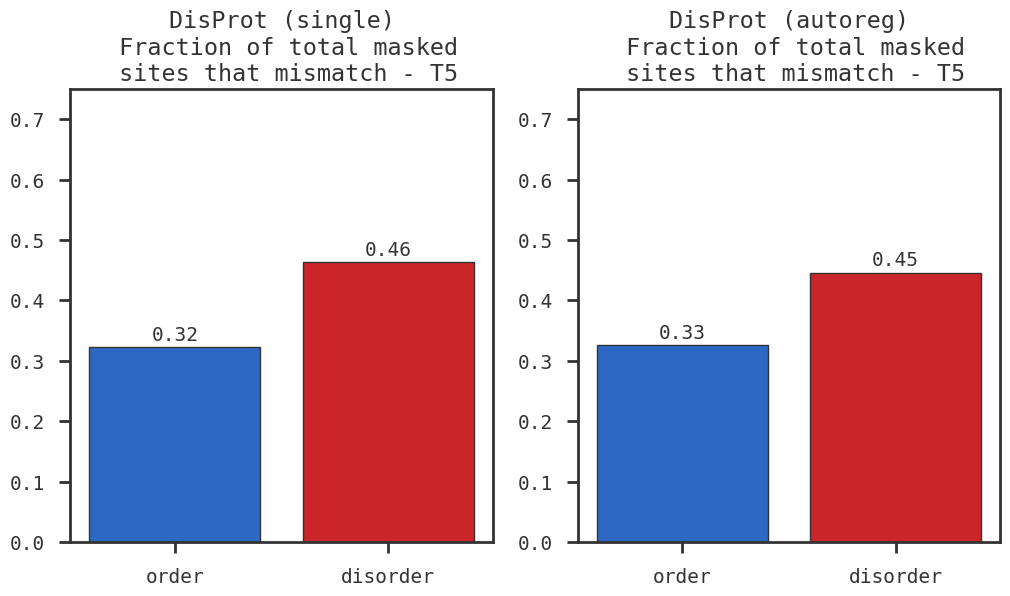

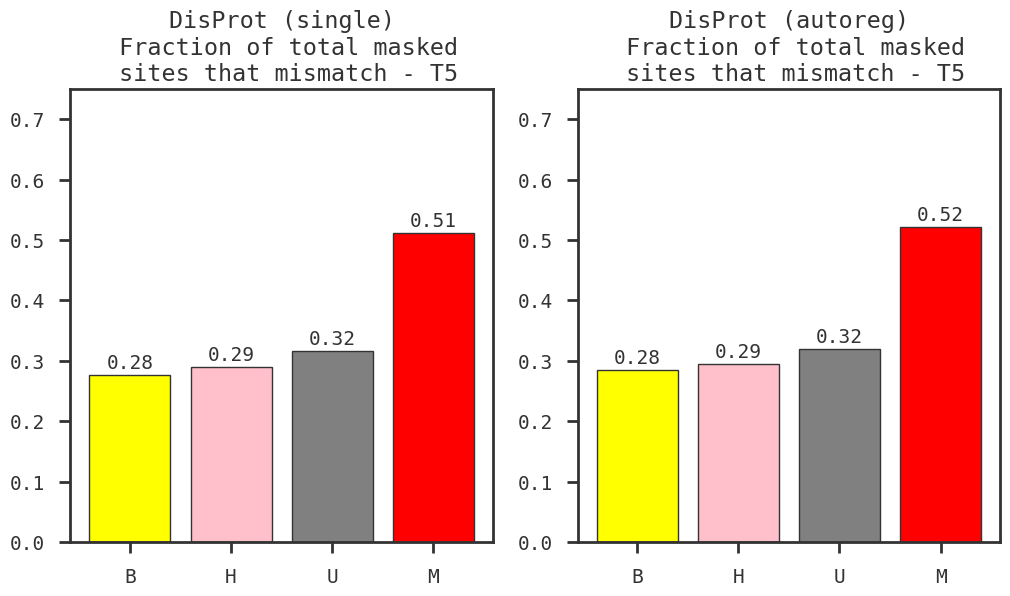

In [26]:
## If the mask is put in a disordered region, what happens?
## compare mismatch counts wrt protein length

print(f"Total disordered residues: {disprot_results_dict['total_diso']}")
print(f"Total ordered residues: {disprot_results_dict['total_order']}")

total_residues = disprot_results_dict["total_diso"] + disprot_results_dict["total_order"]
print(f"Total residues: {total_residues}")

print(f"Total B residues: {disprot_results_dict['total_B']} ({disprot_results_dict['total_B']/total_residues})")
print(f"Total H residues: {disprot_results_dict['total_H']} ({disprot_results_dict['total_H']/total_residues})")
print(f"Total U residues: {disprot_results_dict['total_U']} ({disprot_results_dict['total_U']/total_residues})")
print(f"Total M residues: {disprot_results_dict['total_M']} ({disprot_results_dict['total_M']/total_residues})")


def get_fractions(prot_dict, mismatch_count_dict, total_residues_type, label):
    fraction_mm_at0 = list()
    mm_at0 = 0
    for prot_id in mismatch_count_dict.keys():
        seq_len = len(prot_dict[prot_id]['seq'])
        fraction_mm = mismatch_count_dict[prot_id][0]/seq_len
        mm_at0 += mismatch_count_dict[prot_id][0]
        fraction_mm_at0.append(fraction_mm)

    fraction_mm_at0 = np.array(fraction_mm_at0)
    print(f"Fraction of total {label} residues that mismatch: {mm_at0/total_residues_type:.2f} ({mm_at0} of {total_residues_type})")
    return mm_at0/total_residues_type

Dfraction = get_fractions(disprot_dict, disprot_results_dict["mm_diso"], disprot_results_dict["total_diso"], "Disorder")
Ofraction = get_fractions(disprot_dict, disprot_results_dict["mm_order"], disprot_results_dict["total_order"], "Order")
Bfraction = get_fractions(disprot_dict, disprot_results_dict["mm_B"], disprot_results_dict["total_B"], "B")
Hfraction = get_fractions(disprot_dict, disprot_results_dict["mm_H"], disprot_results_dict["total_H"], "H")
Ufraction = get_fractions(disprot_dict, disprot_results_dict["mm_U"], disprot_results_dict["total_U"], "U")
Mfraction = get_fractions(disprot_dict, disprot_results_dict["mm_M"], disprot_results_dict["total_M"], "M")




print("========= Autoregressive =============")
print(f"Total disordered residues: {disprot_results_autoreg_dict['total_diso']}")
print(f"Total ordered residues: {disprot_results_autoreg_dict['total_order']}")

total_residues_autoreg = disprot_results_autoreg_dict["total_diso"] + disprot_results_autoreg_dict["total_order"]
print(f"Total residues: {total_residues_autoreg}")

print(f"Total B residues: {disprot_results_autoreg_dict['total_B']} ({disprot_results_autoreg_dict['total_B']/total_residues_autoreg})")
print(f"Total H residues: {disprot_results_autoreg_dict['total_H']} ({disprot_results_autoreg_dict['total_H']/total_residues_autoreg})")
print(f"Total U residues: {disprot_results_autoreg_dict['total_U']} ({disprot_results_autoreg_dict['total_U']/total_residues_autoreg})")
print(f"Total M residues: {disprot_results_autoreg_dict['total_M']} ({disprot_results_autoreg_dict['total_M']/total_residues_autoreg})")


Dfraction_autoreg = get_fractions(disprot_dict, disprot_results_autoreg_dict["mm_diso"], disprot_results_autoreg_dict["total_diso"], "Disorder")
Ofraction_autoreg = get_fractions(disprot_dict, disprot_results_autoreg_dict["mm_order"], disprot_results_autoreg_dict["total_order"], "Order")
Bfraction_autoreg = get_fractions(disprot_dict, disprot_results_autoreg_dict["mm_B"], disprot_results_autoreg_dict["total_B"], "B")
Hfraction_autoreg = get_fractions(disprot_dict, disprot_results_autoreg_dict["mm_H"], disprot_results_autoreg_dict["total_H"], "H")
Ufraction_autoreg = get_fractions(disprot_dict, disprot_results_autoreg_dict["mm_U"], disprot_results_autoreg_dict["total_U"], "U")
Mfraction_autoreg = get_fractions(disprot_dict, disprot_results_autoreg_dict["mm_M"], disprot_results_autoreg_dict["total_M"], "M")


mpl_stylesheet.banskt_presentation(fontfamily = 'mono', fontsize = 14, colors = 'banskt', dpi = 100)

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121)
b = ax1.bar(x = np.arange(2), height = [Ofraction, 0]) #, tick_label=["order", "disorder"])
b = ax1.bar(x = np.arange(2), height = [0, Dfraction], tick_label=["order", "disorder"])

for bar in ax1.patches:
    if bar.get_height() > 0:
        ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height()+0.02,
                 format(bar.get_height(), '.2f'), 
                 ha='center', va='center')
ax1.set_ylim(0,0.75)
ax1.set_title("DisProt (single)\n Fraction of total masked\n sites that mismatch - T5", ha='center')

ax2 = fig.add_subplot(122)
b = ax2.bar(x = np.arange(2), height = [Ofraction_autoreg, 0]) #, tick_label=["order", "disorder"])
b = ax2.bar(x = np.arange(2), height = [0, Dfraction_autoreg], tick_label=["order", "disorder"])

for bar in ax2.patches:
    if bar.get_height() > 0:
        ax2.text(bar.get_x() + bar.get_width() / 2, bar.get_height()+0.02,
                 format(bar.get_height(), '.2f'), 
                 ha='center', va='center')
ax2.set_ylim(0,0.75)
ax2.set_title("DisProt (autoreg)\n Fraction of total masked\n sites that mismatch - T5", ha='center')
plt.show()


###############

fig2 = plt.figure(figsize=(12,6))
ax3 = fig2.add_subplot(121)
b = ax3.bar(x = np.arange(4), height = [Bfraction, 0, 0, 0], color="yellow")
b = ax3.bar(x = np.arange(4), height = [0, Hfraction, 0, 0], color="pink")
b = ax3.bar(x = np.arange(4), height = [0, 0, Ufraction, 0], color="gray")
b = ax3.bar(x = np.arange(4), height = [0, 0, 0, Mfraction], tick_label=["B", "H", "U", "M"], color="red")

for bar in ax3.patches:
    if bar.get_height() > 0:
        ax3.text(bar.get_x() + bar.get_width() / 2, bar.get_height()+0.02,
                 format(bar.get_height(), '.2f'), 
                 ha='center', va='center')
ax3.set_ylim(0,0.75)
ax3.set_title("DisProt (single)\n Fraction of total masked\n sites that mismatch - T5", ha='center')


ax2 = fig2.add_subplot(122)
b = ax2.bar(x = np.arange(4), height = [Bfraction_autoreg, 0, 0, 0], color="yellow")
b = ax2.bar(x = np.arange(4), height = [0, Hfraction_autoreg, 0, 0], color="pink")
b = ax2.bar(x = np.arange(4), height = [0, 0, Ufraction_autoreg, 0], color="gray")
b = ax2.bar(x = np.arange(4), height = [0, 0, 0, Mfraction_autoreg], tick_label=["B", "H", "U", "M"], color="red")

for bar in ax2.patches:
    if bar.get_height() > 0:
        ax2.text(bar.get_x() + bar.get_width() / 2, bar.get_height()+0.02,
                 format(bar.get_height(), '.2f'), 
                 ha='center', va='center')
ax2.set_ylim(0,0.75)
ax2.set_title("DisProt (autoreg)\n Fraction of total masked\n sites that mismatch - T5", ha='center')
plt.show()

In [27]:
# ## If the mask is put in a disordered region, what happens?
# ## compare mismatch counts wrt protein length

# print(f"Total disordered residues: {total_residues_disorder}")
# print(f"Total ordered residues: {total_residues_order}")

# total_residues = total_residues_disorder + total_residues_order
# print(f"Total residues: {total_residues}")

# print(f"Total B residues: {total_residues_B} ({total_residues_B/total_residues})")
# print(f"Total H residues: {total_residues_H} ({total_residues_H/total_residues})")
# print(f"Total U residues: {total_residues_U} ({total_residues_U/total_residues})")
# print(f"Total M residues: {total_residues_M} ({total_residues_M/total_residues})")


# def get_fractions(prot_dict, mismatch_count_dict, total_residues_type, label):
#     fraction_mm_at0 = list()
#     mm_at0 = 0
#     for prot_id in mismatch_count_dict.keys():
#         seq_len = len(prot_dict[prot_id]['seq'])
#         fraction_mm = mismatch_count_dict[prot_id][0]/seq_len
#         mm_at0 += mismatch_count_dict[prot_id][0]
#         fraction_mm_at0.append(fraction_mm)

#     fraction_mm_at0 = np.array(fraction_mm_at0)
#     print(f"Fraction of total {label} residues that mismatch: {mm_at0/total_residues_type:.2f} ({mm_at0} of {total_residues_type})")
#     return mm_at0/total_residues_type

# Dfraction = get_fractions(disprot_dict, mismatch_count_dict_maskdiso, total_residues_disorder, "Disorder")
# Ofraction = get_fractions(disprot_dict, mismatch_count_dict_maskordr, total_residues_order, "Order")

# Bfraction = get_fractions(disprot_dict, mismatch_count_dict_maskB, total_residues_B, "B")
# Hfraction = get_fractions(disprot_dict, mismatch_count_dict_maskH, total_residues_H, "H")
# Ufraction = get_fractions(disprot_dict, mismatch_count_dict_maskU, total_residues_U, "U")
# Mfraction = get_fractions(disprot_dict, mismatch_count_dict_maskM, total_residues_M, "M")


# mpl_stylesheet.banskt_presentation(fontfamily = 'mono', fontsize = 14, colors = 'banskt', dpi = 100)

# fig = plt.figure(figsize=(6,6))
# ax1 = fig.add_subplot(111)
# b = ax1.bar(x = np.arange(2), height = [Ofraction, 0]) #, tick_label=["order", "disorder"])
# b = ax1.bar(x = np.arange(2), height = [0, Dfraction], tick_label=["order", "disorder"])

# for bar in ax1.patches:
#     if bar.get_height() > 0:
#         ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height()+0.02,
#                  format(bar.get_height(), '.2f'), 
#                  ha='center', va='center')
# ax1.set_ylim(0,0.75)
# ax1.set_title("DisProt: Fraction of total masked\n sites that mismatch - T5", ha='center')
# plt.show()

# fig = plt.figure(figsize=(6,6))
# ax1 = fig.add_subplot(111)
# b = ax1.bar(x = np.arange(4), height = [Bfraction, 0, 0, 0], color="yellow")
# b = ax1.bar(x = np.arange(4), height = [0, Hfraction, 0, 0], color="pink")
# b = ax1.bar(x = np.arange(4), height = [0, 0, Ufraction, 0], color="gray")
# b = ax1.bar(x = np.arange(4), height = [0, 0, 0, Mfraction], tick_label=["B", "H", "U", "M"], color="red")

# for bar in ax1.patches:
#     if bar.get_height() > 0:
#         ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height()+0.02,
#                  format(bar.get_height(), '.2f'), 
#                  ha='center', va='center')
# ax1.set_ylim(0,0.75)
# ax1.set_title("DisProt: Fraction of total masked\n sites that mismatch - T5", ha='center')
# plt.show()


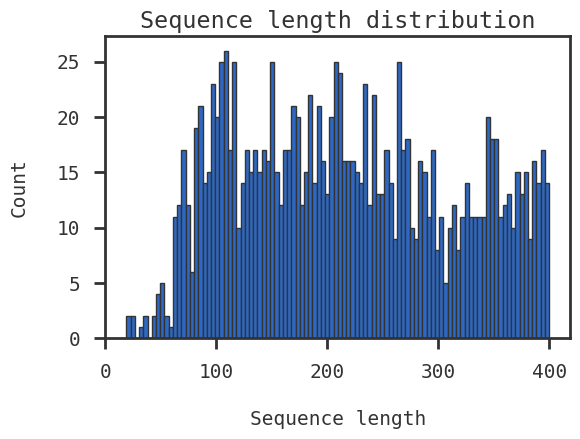

In [28]:
disprot_lengths = []
for disprot_id in disprot_dict.keys():
    disprot_lengths.append(len(disprot_dict[disprot_id]['seq']))

plt.figure(figsize=(6, 4))
plt.hist(disprot_lengths, bins=100)
plt.xlabel("Sequence length")
plt.ylabel("Count")
plt.title("Sequence length distribution")
plt.show()


In [29]:
collapsed_mismatch_count_dict = collections.defaultdict(int)
for disprot_id in disprot_results_dict['mm_counts']:
    for k in disprot_results_dict['mm_counts'][disprot_id]:
        collapsed_mismatch_count_dict[k] += disprot_results_dict['mm_counts'][disprot_id][k]


collapsed_mismatch_count_dict_autoreg = collections.defaultdict(int)
for disprot_id in disprot_results_autoreg_dict['mm_counts']:
    for k in disprot_results_autoreg_dict['mm_counts'][disprot_id]:
        collapsed_mismatch_count_dict_autoreg[k] += disprot_results_autoreg_dict['mm_counts'][disprot_id][k]


In [30]:
disprot_results_autoreg_dict['mm_counts']

{'P49913': defaultdict(int, {1: 82, 0: 74}),
 'P03045': defaultdict(int, {1: 86, 0: 85}),
 'P00004': defaultdict(int, {1: 7, 0: 5}),
 'P27695': defaultdict(int,
             {1: 45,
              0: 42,
              3: 1,
              4: 1,
              5: 1,
              6: 1,
              7: 1,
              8: 1,
              9: 1,
              10: 1,
              11: 1,
              12: 1,
              13: 1,
              14: 1,
              15: 1,
              16: 1,
              17: 1,
              18: 1,
              19: 1,
              20: 1,
              21: 1,
              22: 1,
              23: 1,
              24: 1,
              25: 1,
              26: 1,
              27: 1,
              28: 1,
              29: 1,
              30: 1,
              31: 1,
              32: 1,
              33: 1,
              34: 1,
              35: 1,
              36: 1,
              37: 1,
              38: 1,
              39: 1,
              40: 1,
      

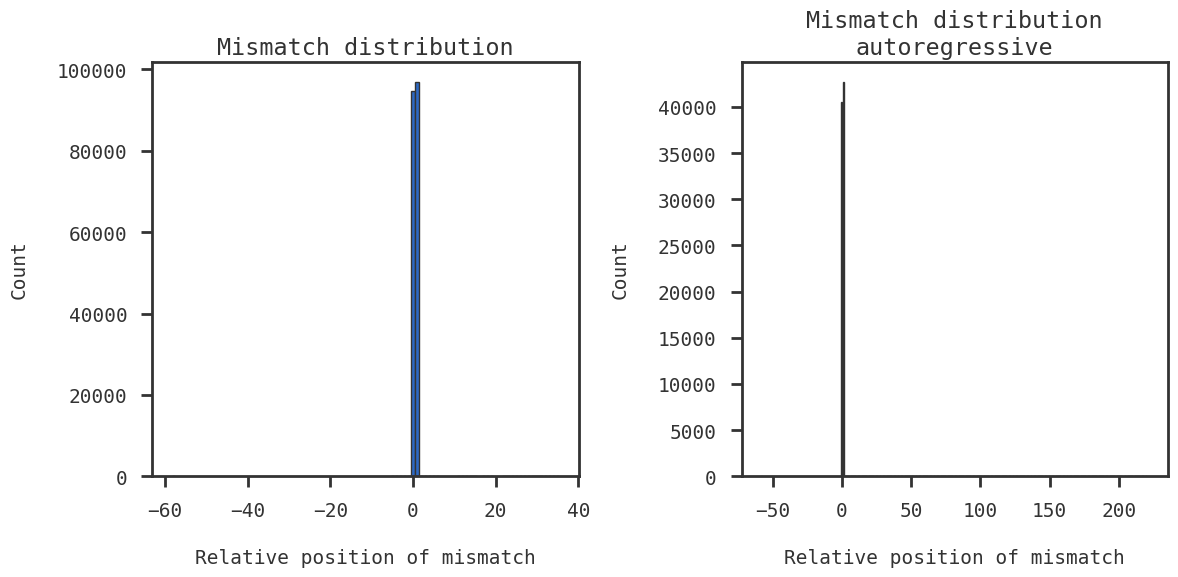

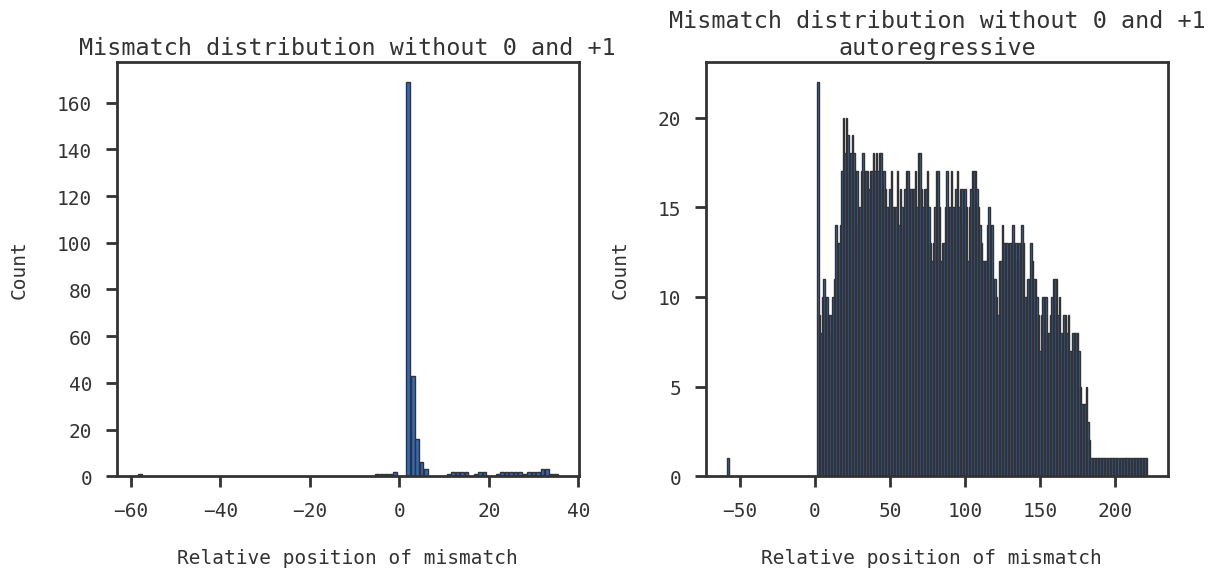

In [31]:
# sort by key and get a list of keys and values
sorted_keys = sorted(collapsed_mismatch_count_dict.keys())
sorted_values = [collapsed_mismatch_count_dict[k] for k in sorted_keys]
ix01 = [i for i,v in enumerate(sorted_keys) if v != 0 and v != 1]

sorted_keys_autoreg = sorted(collapsed_mismatch_count_dict_autoreg.keys())
sorted_values_autoreg = [collapsed_mismatch_count_dict_autoreg[k] for k in sorted_keys_autoreg]
ix01_autoreg = [i for i,v in enumerate(sorted_keys_autoreg) if v != 0 and v != 1]

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121)
ax1.bar(sorted_keys, sorted_values)
ax1.set_xlabel("Relative position of mismatch")
ax1.set_ylabel("Count")
ax1.set_title("Mismatch distribution")

ax2 = fig.add_subplot(122)
ax2.bar(sorted_keys_autoreg, sorted_values_autoreg)
ax2.set_xlabel("Relative position of mismatch")
ax2.set_ylabel("Count")
ax2.set_title("Mismatch distribution\nautoregressive")
plt.tight_layout()
plt.show()



fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121)
ax1.bar([sorted_keys[i] for i in ix01], [sorted_values[i] for i in ix01])
ax1.set_xlabel("Relative position of mismatch")
ax1.set_ylabel("Count")
ax1.set_title("Mismatch distribution without 0 and +1")

ax2 = fig.add_subplot(122)
ax2.bar([sorted_keys_autoreg[i] for i in ix01_autoreg], [sorted_values_autoreg[i] for i in ix01_autoreg])
ax2.set_xlabel("Relative position of mismatch ")
ax2.set_ylabel("Count")
ax2.set_title("Mismatch distribution without 0 and +1\nautoregressive")
plt.tight_layout()
plt.show()


In [43]:
disprot_dict_long = collections.defaultdict(dict)

with open("/biodata/franco/zsuzsa_lab/longseq_testset_sequences.fasta") as instrm:
    for record in SeqIO.parse(instrm, "fasta"):
            disprot_dict_long[record.id]['seq'] = str(record.seq)

with open("/biodata/franco/datasets/disprot/disprot_OK_fullset_annotations_2023_12.fasta") as instrm:
    for record in SeqIO.parse(instrm, "fasta"):
            if record.id in disprot_dict_long:
                disprot_dict_long[record.id]['disorder'] = str(record.seq)

for protid in disprot_dict_long:
    if protid in disprot_dict_full:
        if 'ss' in disprot_dict_full[protid]:
            disprot_dict_long[protid]['ss'] = disprot_dict_full[protid]['ss']
            print("yes")
        else:
            print("no")
    else:
        print("nono")

yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes


In [44]:
disprot_long_matches_data_autoreg = load_match_data(disprot_dict_long, "/biodata/franco/zsuzsa_lab/loss_T5_longseq_autoreg")
disprot_long_matches_data         = load_match_data(disprot_dict_long, "/biodata/franco/zsuzsa_lab/loss_T5_disprot2_cuda")


disprot_long_results_dict = process_mismatch_data(disprot_dict_long, disprot_long_matches_data)
disprot_long_results_autoreg_dict = process_mismatch_data(disprot_dict_long, disprot_long_matches_data_autoreg)

Missing 0 files
Loaded 11 files
Missing 0 files
Loaded 11 files


100%|██████████| 11/11 [00:00<00:00, 64.85it/s]


In [47]:
df_long = pd.DataFrame([])
for disprot_id in disprot_long_results_dict['mm_counts']:
    temp_list = list()
    protlen = len(disprot_dict_long[disprot_id]['seq'])
    len_bin = int(np.floor(protlen/200)*200)
    for k in disprot_long_results_dict['mm_counts'][disprot_id]:
        temp_list.append([disprot_id, k, disprot_long_results_dict['mm_counts'][disprot_id][k], protlen, len_bin])
    df_long = pd.concat([df_long, pd.DataFrame(temp_list, columns = ['disprot_id', 'relative_pos', 'count', 'protlen', 'len_bin'])])

df_long_no01 = df_long[(df_long['relative_pos'] != 0) & (df_long['relative_pos'] != 1) & (df_long['relative_pos'] != 2) & (df_long['relative_pos'] != 3)]
df_long_no01['disprot_id'].nunique()


11

In [52]:

df_long_autoreg = pd.DataFrame([])
for disprot_id in disprot_long_results_autoreg_dict['mm_counts']:
    temp_list = list()
    protlen = len(disprot_dict_long[disprot_id]['seq'])
    len_bin = int(np.floor(protlen/200)*200)
    for k in disprot_long_results_autoreg_dict['mm_counts'][disprot_id]:
        temp_list.append([disprot_id, k, disprot_long_results_autoreg_dict['mm_counts'][disprot_id][k], protlen, len_bin])
    df_long_autoreg = pd.concat([df_long_autoreg, pd.DataFrame(temp_list, columns = ['disprot_id', 'relative_pos', 'count', 'protlen', 'len_bin'])])

print(df_long_autoreg['disprot_id'].nunique())
df_long_autoreg_no01 = df_long_autoreg[(df_long_autoreg['relative_pos'] != 0) & (df_long_autoreg['relative_pos'] != 1)]
df_long_autoreg_no01['disprot_id'].nunique()

11


9

[800]


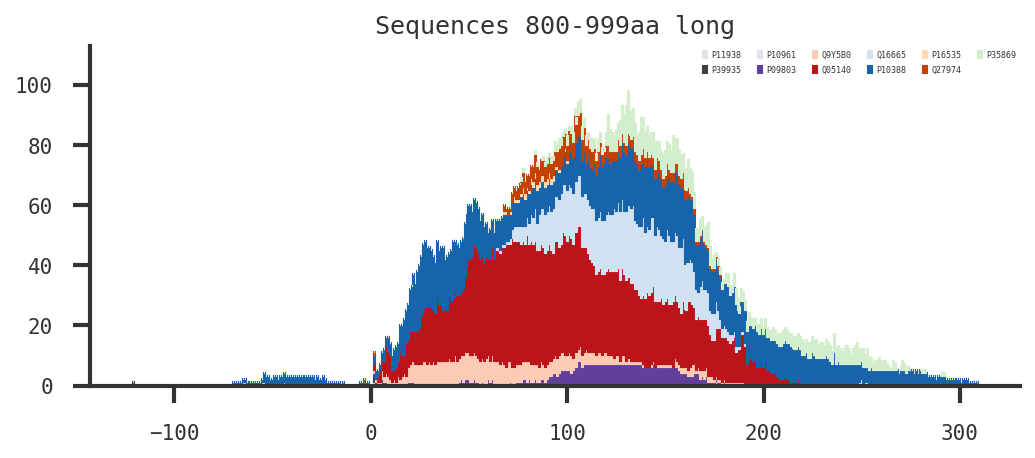

[800]


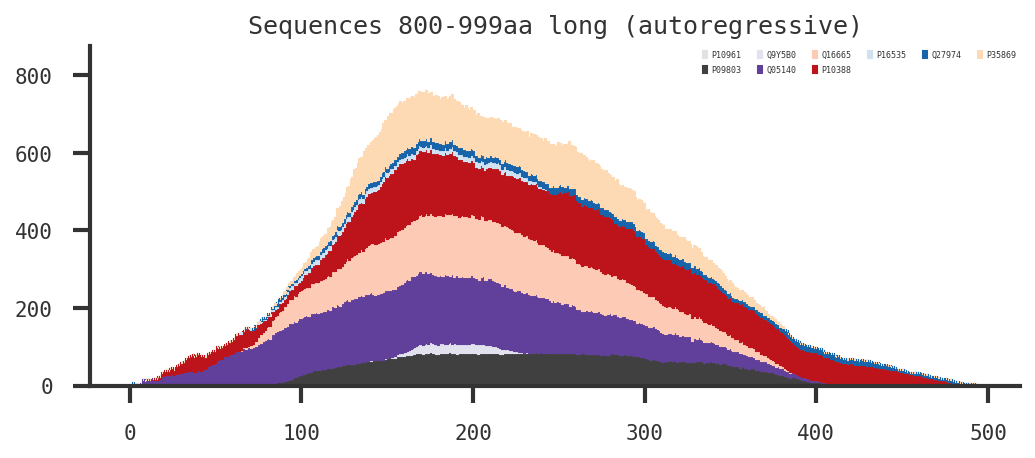

In [53]:
import seaborn as sns
import matplotlib

#df_no01 = df[(df['relative_pos'] != 0) & (df['relative_pos'] != 1) & (df['relative_pos'] != 2) & (df['relative_pos'] != 3)]
df_no01 = df_long[(df_long['relative_pos'] != 0) & (df_long['relative_pos'] != 1) ]
len_bins = sorted(df_no01['len_bin'].unique())
print(len_bins)

mpl_stylesheet.banskt_presentation(fontfamily = 'mono', fontsize = 10, colors = 'banskt', dpi = 150)
N = 10 # number of colors to extract from each of the base_cmaps below
base_cmaps = ['Greys','Purples','Reds','Blues','Oranges','Greens']
n_base = len(base_cmaps)

# find all the available "relative_pos" 
relative_pos = sorted(df_no01['relative_pos'].unique())
for len_bin in len_bins:
    fig = plt.figure(figsize=(8, 3))
    ax = fig.add_subplot(111)
    width = 0.5
    df_no01_crop = df_no01[df_no01['len_bin'] == len_bin]
    #ax = axes[len_bins.index(len_bin)]

    disprot_ids = df_no01_crop['disprot_id'].unique()

    N = int(np.ceil(len(disprot_ids)/len(base_cmaps)))
    # we go from 0.2 to 0.8 below to avoid having several whites and blacks in the resulting cmaps
    colors = np.concatenate([matplotlib.colormaps[name](np.linspace(0.2,0.8,N)) for name in base_cmaps])
    cmap = matplotlib.colors.ListedColormap(colors)

    bottom = np.zeros(len(relative_pos))
    # for each disprot_id, make a vector of the height value at each relative_pos
    all_bardata = list()
    for j, did in enumerate(disprot_ids):
        did_vector = np.zeros(len(relative_pos))
        for i,row in df_no01_crop[df_no01_crop.disprot_id == did].sort_values("relative_pos").iterrows():
            did_vector[relative_pos.index(row["relative_pos"])] = row["count"]
        ax.bar(relative_pos, did_vector, width, label=did, bottom=bottom, color=cmap(j), edgecolor=cmap(j))
        ax.legend(ncol=len(base_cmaps), prop={'size': 4})
        
        # eliminate axis borders
        bottom += did_vector

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ymin, ymax = ax.get_ylim()
    ax.set_ylim(ymin, ymax+int(ymax*0.1))
    ax.set_title(f"Sequences {len_bin}-{len_bin+199}aa long")
    plt.show()


df_no01 = df_long_autoreg[(df_long_autoreg['relative_pos'] != 0) & (df_long_autoreg['relative_pos'] != 1) ]
len_bins = sorted(df_no01['len_bin'].unique())
print(len_bins)

mpl_stylesheet.banskt_presentation(fontfamily = 'mono', fontsize = 10, colors = 'banskt', dpi = 150)
N = 10 # number of colors to extract from each of the base_cmaps below
base_cmaps = ['Greys','Purples','Reds','Blues','Oranges','Greens']
n_base = len(base_cmaps)

# find all the available "relative_pos" 
relative_pos = sorted(df_no01['relative_pos'].unique())
for len_bin in len_bins:
    fig = plt.figure(figsize=(8, 3))
    ax = fig.add_subplot(111)
    width = 0.5
    df_no01_crop = df_no01[df_no01['len_bin'] == len_bin]
    #ax = axes[len_bins.index(len_bin)]

    disprot_ids = df_no01_crop['disprot_id'].unique()

    N = int(np.ceil(len(disprot_ids)/len(base_cmaps)))
    # we go from 0.2 to 0.8 below to avoid having several whites and blacks in the resulting cmaps
    colors = np.concatenate([matplotlib.colormaps[name](np.linspace(0.2,0.8,N)) for name in base_cmaps])
    cmap = matplotlib.colors.ListedColormap(colors)

    bottom = np.zeros(len(relative_pos))
    # for each disprot_id, make a vector of the height value at each relative_pos
    all_bardata = list()
    for j, did in enumerate(disprot_ids):
        did_vector = np.zeros(len(relative_pos))
        for i,row in df_no01_crop[df_no01_crop.disprot_id == did].sort_values("relative_pos").iterrows():
            did_vector[relative_pos.index(row["relative_pos"])] = row["count"]
        ax.bar(relative_pos, did_vector, width, label=did, bottom=bottom, color=cmap(j), edgecolor=cmap(j))
        ax.legend(ncol=len(base_cmaps), prop={'size': 4})
        
        # eliminate axis borders
        bottom += did_vector

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ymin, ymax = ax.get_ylim()
    ax.set_ylim(ymin, ymax+int(ymax*0.1))
    ax.set_title(f"Sequences {len_bin}-{len_bin+199}aa long (autoregressive)")
    plt.show()


In [111]:
def get_mismatch_count_matrix(prot_dict, matches_dict):
    wrong_aa = list()
    not_valid_aa = list()

    mismatch_count_matrix = np.zeros((1000,1000))
    
    for prot_id in tqdm(matches_dict.keys()):
        seq = prot_dict[prot_id]['seq']
        ss_seq = prot_dict[prot_id]['ss']
        disorder = prot_dict[prot_id]['disorder']
        matches = matches_dict[prot_id]['match']
        
        diso_ix = [True if e != "-" else False for e in disorder ]

        assert len(matches) == len(seq)
        for current_pos, match in enumerate(matches):

            #check if match is bool or list
            #check if match is bool or list
            if type(match) == bool:
                if match == False:
                    ## incorrect number of aa's predicted, longer or shorter sequence
                    continue
                else:
                    ## this entire sequence was predicted accurately
                    pass
            else:
                for m in match:
                    mismatch_pos, aa_predicted, aa_orig = m
                    if (aa_orig not in aa_vocab_list) or (seq[mismatch_pos] not in aa_vocab_list):
                        not_valid_aa.append((disprot_id, mismatch_pos, aa_orig, seq[mismatch_pos]))
                        continue
                    
                    if aa_orig != seq[mismatch_pos]:
                        wrong_aa.append((disprot_id, mismatch_pos, aa_orig, seq[mismatch_pos]))
                        continue
                    
                    relative_pos = mismatch_pos - current_pos
                    if np.abs(relative_pos) > 3:
                        mismatch_count_matrix[current_pos, mismatch_pos] += 1
            for j in range(current_pos, len(seq)):
                if diso_ix[current_pos] and diso_ix[j]:
                    mismatch_count_matrix[j,current_pos] += 1
    return mismatch_count_matrix

def get_mismatch_count_matrix_single_prot(prot_dict, matches_dict):
    wrong_aa = list()
    not_valid_aa = list()

    mismatch_count_matrix = np.zeros((1000,1000))
    
    for prot_id in tqdm(matches_dict.keys()):
        seq = prot_dict[prot_id]['seq']
        ss_seq = prot_dict[prot_id]['ss']
        disorder = prot_dict[prot_id]['disorder']
        matches = matches_dict[prot_id]['match']
        
        diso_ix = [True if e != "-" else False for e in disorder ]

        assert len(matches) == len(seq)
        for current_pos, match in enumerate(matches):

            #check if match is bool or list
            #check if match is bool or list
            if type(match) == bool:
                if match == False:
                    ## incorrect number of aa's predicted, longer or shorter sequence
                    continue
                else:
                    ## this entire sequence was predicted accurately
                    pass
            else:
                for m in match:
                    mismatch_pos, aa_predicted, aa_orig = m
                    if (aa_orig not in aa_vocab_list) or (seq[mismatch_pos] not in aa_vocab_list):
                        not_valid_aa.append((disprot_id, mismatch_pos, aa_orig, seq[mismatch_pos]))
                        continue
                    
                    if aa_orig != seq[mismatch_pos]:
                        wrong_aa.append((disprot_id, mismatch_pos, aa_orig, seq[mismatch_pos]))
                        continue
                    
                    relative_pos = mismatch_pos - current_pos
                    if np.abs(relative_pos) > 3:
                        mismatch_count_matrix[current_pos, mismatch_pos] += 1

            for j in range(current_pos, len(seq)):
                if diso_ix[current_pos] and diso_ix[j]:
                    mismatch_count_matrix[j,current_pos] += 1
    return mismatch_count_matrix

mm_matrix = get_mismatch_count_matrix(disprot_dict_long, disprot_long_matches_data)
mm_matrix_autoreg = get_mismatch_count_matrix(disprot_dict_long, disprot_long_matches_data_autoreg)

  0%|          | 0/11 [00:00<?, ?it/s]

100%|██████████| 11/11 [00:00<00:00, 21.15it/s]


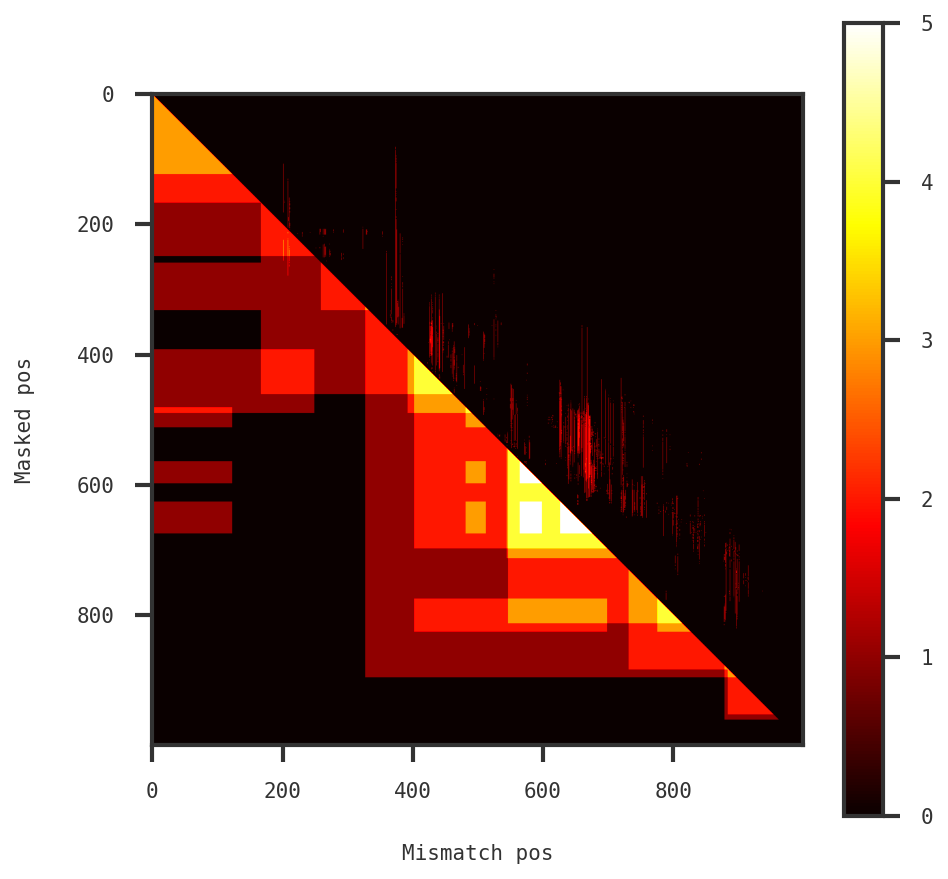

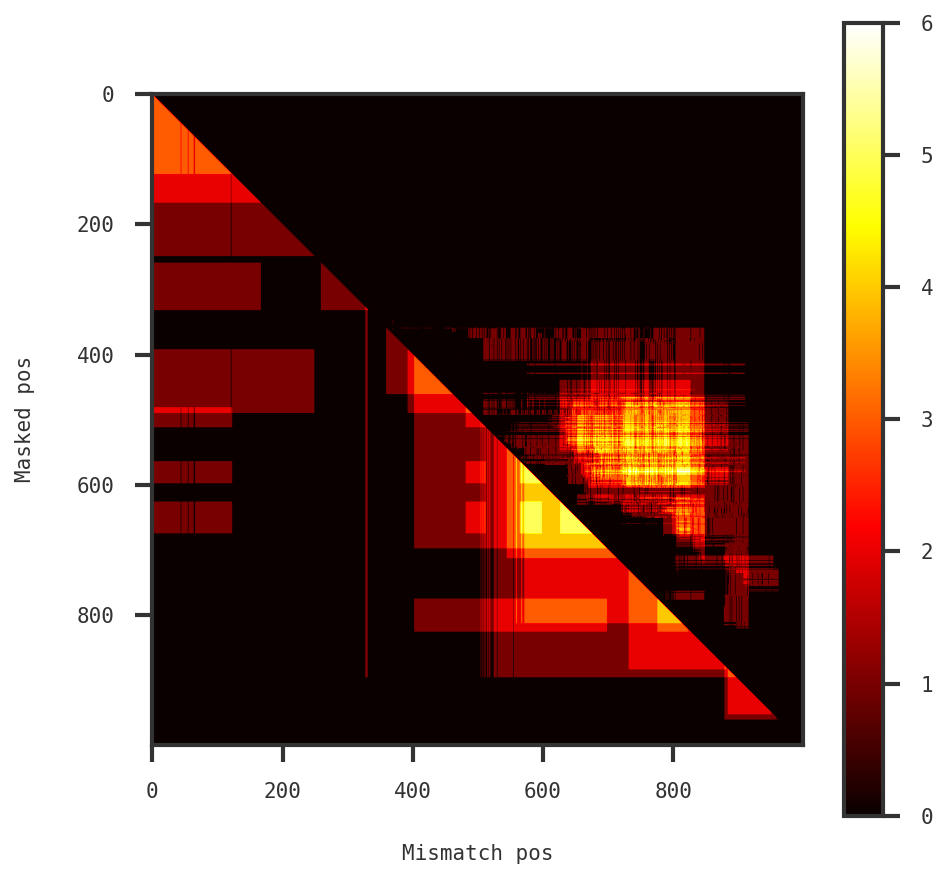

In [112]:
fig = plt.figure(figsize=(7, 7), dpi=150)
plt.imshow(mm_matrix, cmap='hot')
plt.colorbar()
plt.ylabel("Masked pos")
plt.xlabel("Mismatch pos")
plt.show()

fig = plt.figure(figsize=(7, 7), dpi=150)
plt.imshow(mm_matrix_autoreg, cmap='hot')
plt.colorbar()
plt.ylabel("Masked pos")
plt.xlabel("Mismatch pos")
plt.show()



100%|██████████| 1/1 [00:00<00:00, 38.49it/s]

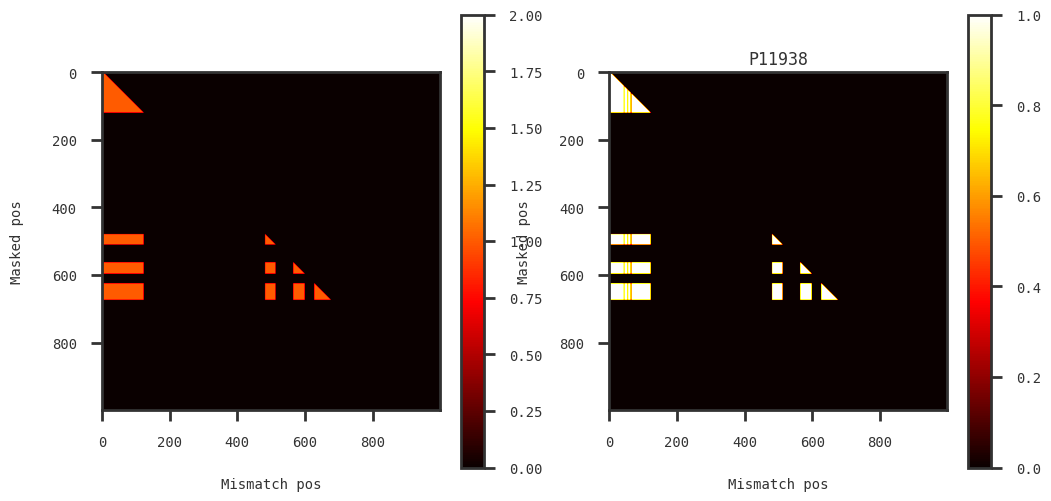

100%|██████████| 1/1 [00:00<00:00, 25.81it/s]


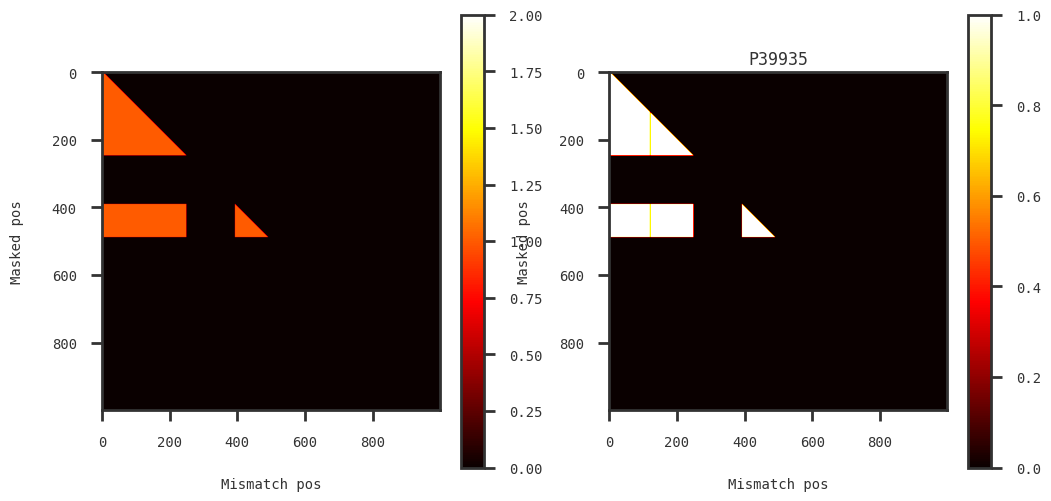

100%|██████████| 1/1 [00:00<00:00, 40.28it/s]


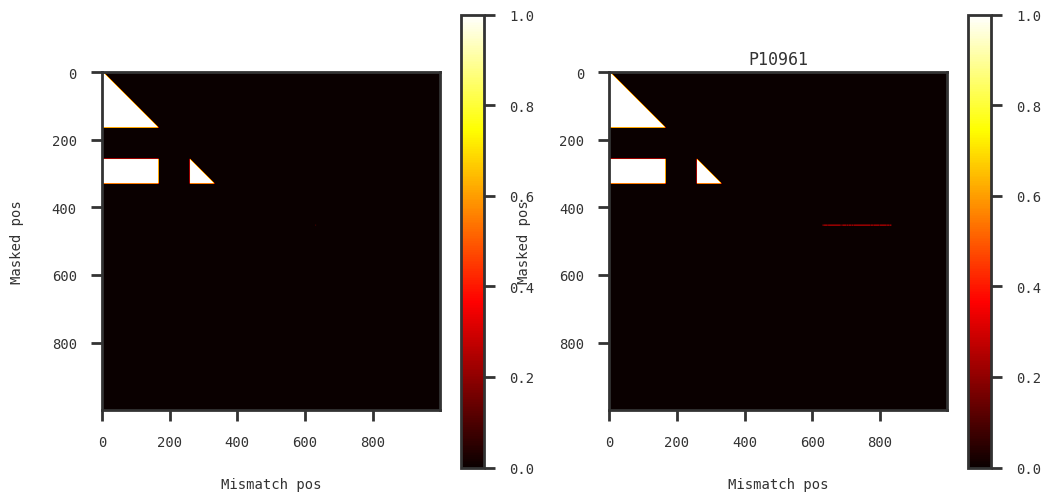

100%|██████████| 1/1 [00:00<00:00, 19.54it/s]


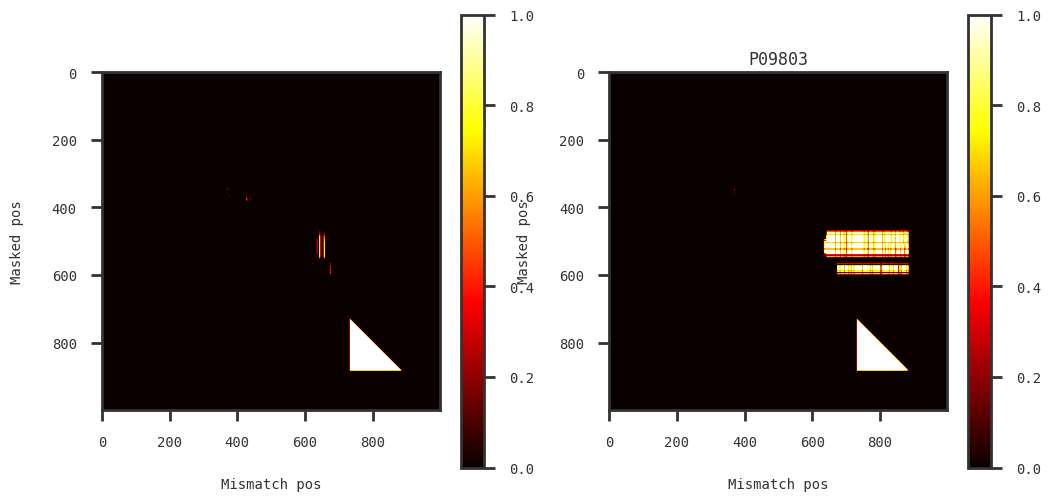

100%|██████████| 1/1 [00:00<00:00, 56.36it/s]


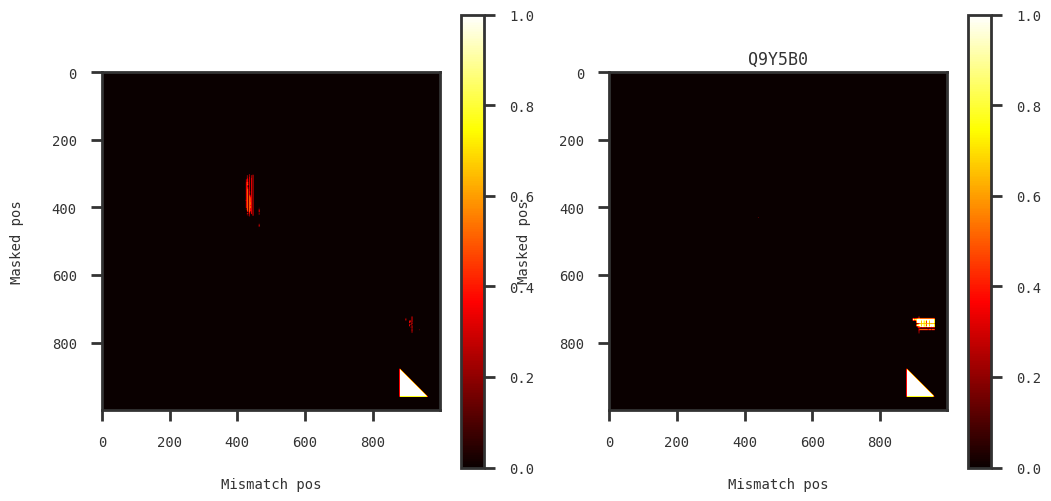

100%|██████████| 1/1 [00:00<00:00,  9.87it/s]


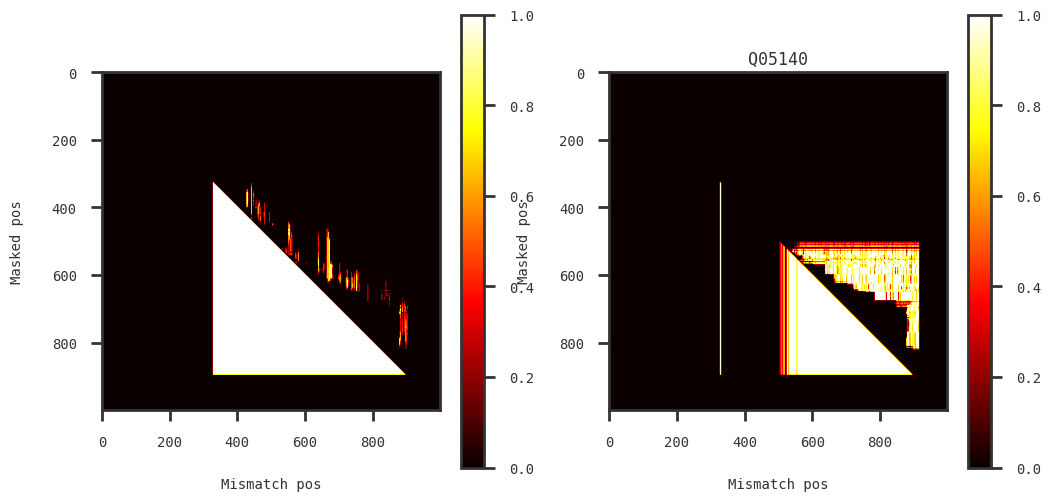

100%|██████████| 1/1 [00:00<00:00, 12.24it/s]


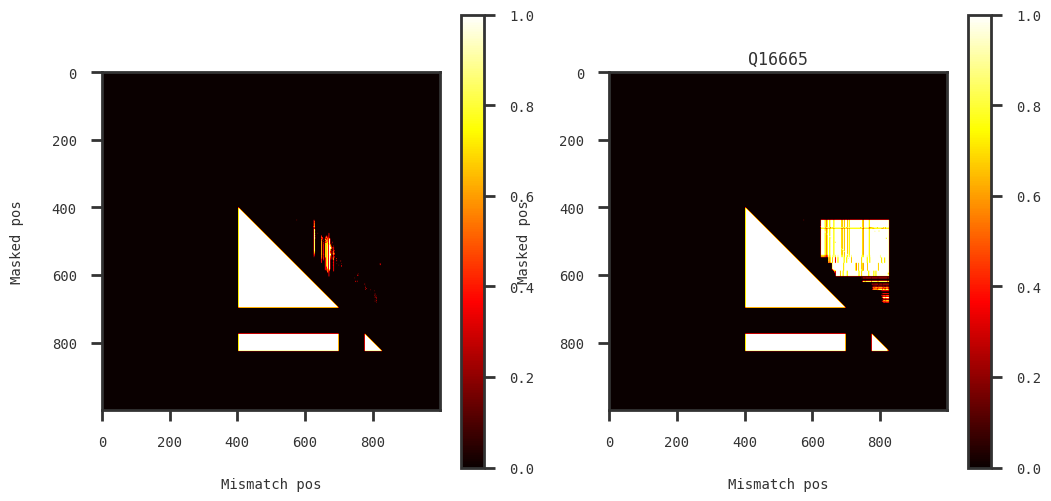

100%|██████████| 1/1 [00:00<00:00, 11.50it/s]


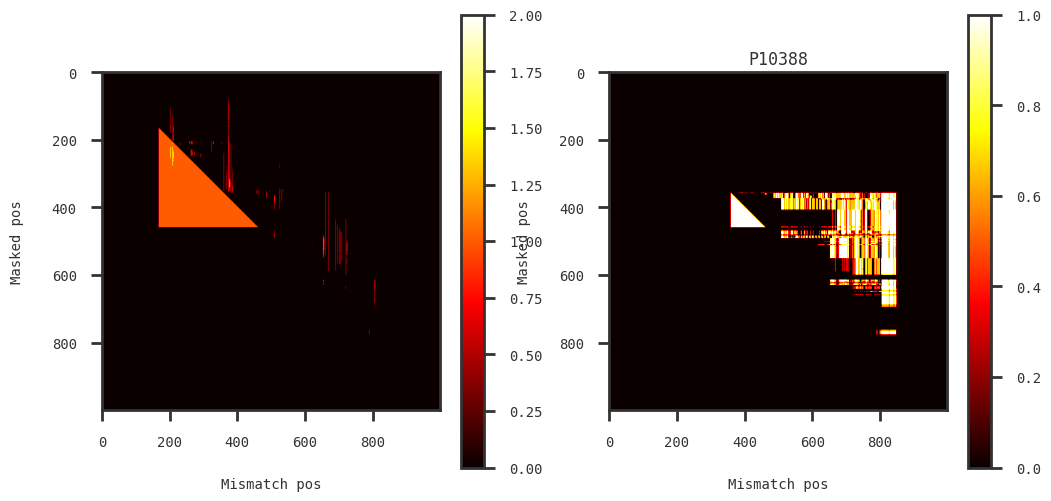

100%|██████████| 1/1 [00:00<00:00, 47.38it/s]


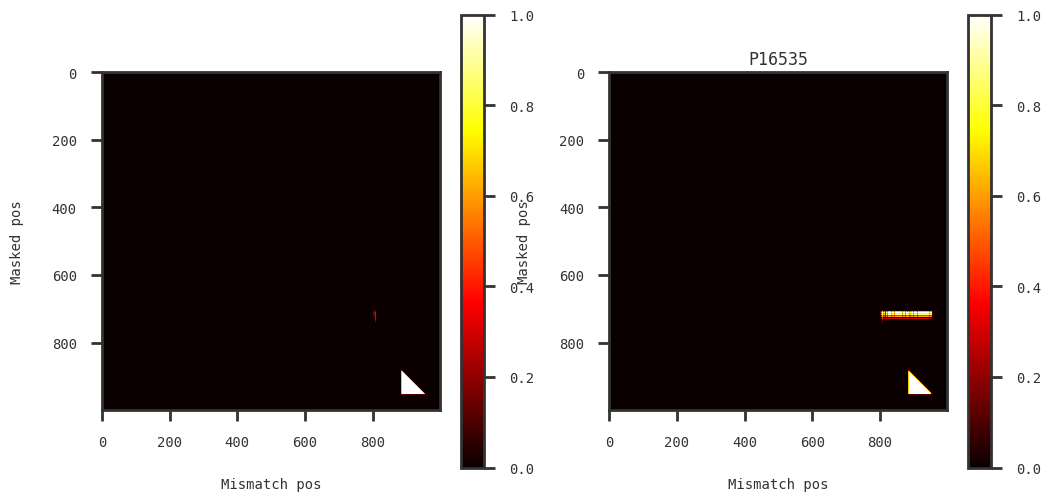

100%|██████████| 1/1 [00:00<00:00, 30.37it/s]


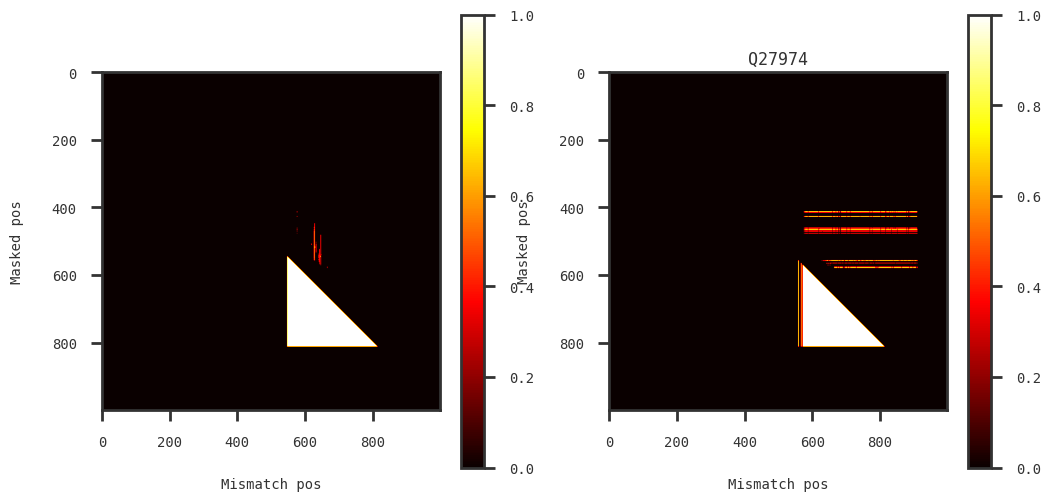

100%|██████████| 1/1 [00:00<00:00, 18.30it/s]


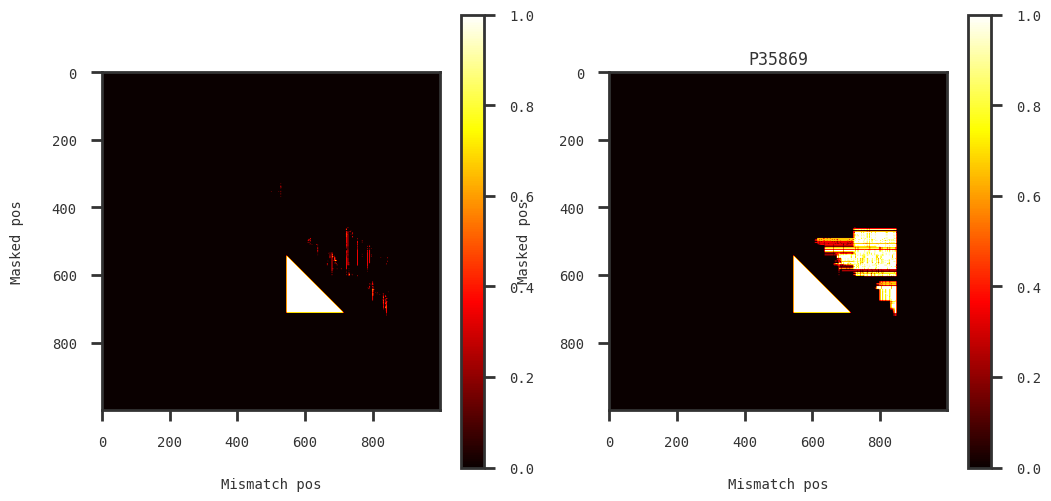

In [113]:
selected_prot = "P11938"

for selected_prot in disprot_dict_long.keys():
    simple_dict = dict()
    simple_dict_autoreg = dict()

    simple_dict[selected_prot] = disprot_long_matches_data[selected_prot]
    simple_dict_autoreg[selected_prot] = disprot_long_matches_data_autoreg[selected_prot]

    mm_matrix = get_mismatch_count_matrix_single_prot(disprot_dict_long, simple_dict)
    mm_matrix_autoreg = get_mismatch_count_matrix_single_prot(disprot_dict_long, simple_dict_autoreg)

    fig = plt.figure(figsize=(12, 6), dpi=100)
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    c1 = ax1.imshow(mm_matrix, cmap='hot')
    c2 = ax2.imshow(mm_matrix_autoreg, cmap='hot')
    ax1.set_ylabel("Masked pos")
    ax1.set_xlabel("Mismatch pos")
    ax2.set_ylabel("Masked pos")
    ax2.set_xlabel("Mismatch pos")
    plt.colorbar(c1, ax=ax1)
    plt.colorbar(c2, ax=ax2)
    plt.title(f"{selected_prot}")
    plt.show()


In [107]:
mm_matrix

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])